In [75]:
import os
import re
import datetime
import pandas as pd
import numpy as np
import json
import geopandas as gpd
import dask_geopandas as dgd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from shapely import box
import datashader as ds
from plotly import express as px
from tqdm import tqdm
import holoviews as hv
from holoviews.operation.datashader import datashade, dynspread
from holoviews.element.tiles import OSM
from datashader.colors import viridis
from datashader import reductions as rd
from bokeh.models import ColorBar, LinearColorMapper, Plot
from bokeh.layouts import column
from bokeh.io import show
import hvplot.pandas
from dotenv import load_dotenv
import dask.dataframe as dd
import dask.distributed
import dask_gateway
from dask.distributed import PipInstall, CondaInstall, WorkerPlugin, Client, get_worker
from dask import delayed
import seaborn as sns
import scipy.stats as stats
from holoviews import opts
from scipy.stats import power_divergence


In [ ]:
gateway = dask_gateway.Gateway()
cluster_options = gateway.cluster_options()
cluster = gateway.new_cluster(cluster_options)
cluster.adapt(minimum=1, maximum=100)
client = dask.distributed.Client(cluster)
client


In [3]:
%load_ext dotenv
load_dotenv()

folder_name = '202205_202209_drought_velocity_profiles'
pathname = 'abfs://ais/parquet/' + folder_name 
sas_token2 = os.environ['SAS_TOKEN2']


ddf = dd.read_parquet(pathname, storage_options={"account_name": "rwsais", "sas_token": sas_token2})

ddf['datetime'] = dd.to_datetime(ddf['datetime'])


In [4]:
# Create two separate dask dataframes where one is in period of 01-05-2022 until 1-07-2022 and the other one from 15-07-2022 to 15-09-2022
normal_period_ddf =ddf[(ddf['datetime'] >= '2022-05-01') & (ddf['datetime'] < '2022-07-01')]
drought_period_ddf = ddf[(ddf['datetime'] >= '2022-07-01') & (ddf['datetime'] <= '2022-09-01')]

normal_period_df = normal_period_ddf.compute()
drought_period_df = drought_period_ddf.compute()

In [5]:
# turn the dataframes into geo dataframes
normal_period_gdf = gpd.GeoDataFrame(normal_period_df, geometry=gpd.points_from_xy(normal_period_df.longitude, normal_period_df.latitude))
drought_period_gdf = gpd.GeoDataFrame(drought_period_df, geometry=gpd.points_from_xy(drought_period_df.longitude, drought_period_df.latitude))

# set datetime as index
# result = classify_trajectories(data)
normal_period_gdf.set_index('datetime', inplace=True)
drought_period_gdf.set_index('datetime', inplace=True)


In [6]:
# Classify trajs for up or downstream
def classify_trajectories(df):
    # Ensure 'cog' values are within the expected range
    df['cog'] = df['cog'] % 360

    # Classify each row based on 'cog' value
    df['own_direction'] = df['cog'].apply(lambda x: 'upstream' if 0 <= x < 180 else 'downstream')

    # Group by 'traj_id' and determine the majority direction for each trajectory
    majority_direction = df.groupby('traj_id')['own_direction'].agg(lambda x: x.mode()[0])

    # Map the majority direction back to the original dataframe
    df['majority_direction'] = df['traj_id'].map(majority_direction)

    # Create the 'upstream' Boolean column based on 'majority_direction'
    df['upstream'] = df['majority_direction'] == 'upstream'

    # Drop the 'majority_direction' column
    df.drop(columns='majority_direction', inplace=True)

    return df

normal_classified = classify_trajectories(normal_period_gdf)
 
drought_classified = classify_trajectories(drought_period_gdf)


In [7]:
# Setting the same crs
normal_classified.crs ='EPSG:4326'
drought_classified.crs = 'EPSG:4326'

In [8]:
normal_classified.to_crs(epsg=3857, inplace=True)
drought_classified.to_crs(epsg=3857, inplace=True)


In [9]:
# knots to kmh
normal_classified['sog'] = normal_classified['sog']*1.852
drought_classified['sog'] = drought_classified['sog']*1.852

In [18]:
normal_classified = normal_classified[normal_classified['sog'] < normal_classified['sog'].quantile(0.99)]
drought_classified = drought_classified[drought_classified['sog'] < drought_classified['sog'].quantile(0.99)]

In [49]:
# make upstream and downstream dataframes for normal and drought
normal_upstream_gdf = normal_classified[normal_classified['upstream']]
normal_downstream_gdf = normal_classified[~normal_classified['upstream']]
drought_upstream_gdf = drought_classified[drought_classified['upstream']]
drought_downstream_gdf = drought_classified[~drought_classified['upstream']]




In [20]:
# check whether there are points with the same trajectory Id in both upstream and downstream dataframes
print(normal_upstream_gdf['traj_id'].isin(normal_downstream_gdf['traj_id']).sum())
print(normal_downstream_gdf['traj_id'].isin(normal_upstream_gdf['traj_id']).sum())

print(drought_downstream_gdf['traj_id'].isin(drought_upstream_gdf['traj_id']).sum())
print(drought_upstream_gdf['traj_id'].isin(drought_downstream_gdf['traj_id']).sum())


0
0
0
0


In [77]:
df_normal = normal_classified.sample(frac=0.1)
df_drought = drought_classified.sample(frac=0.07)

df_normal_down = normal_downstream_gdf.sample(frac=0.1)
df_drought_down = drought_downstream_gdf.sample(frac=0.07)

df_normal_up = normal_upstream_gdf.sample(frac=0.1)
df_drought_up = drought_upstream_gdf.sample(frac=0.07)

In [33]:
gdf['sog'].describe()

count    486545.000000
mean         15.682214
std           3.585058
min           0.000000
25%          15.186400
50%          16.482799
75%          17.408799
max          19.631201
Name: sog, dtype: float64

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
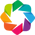

/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [82]:
# Define which gdf to plot
gdf = drought_downstream_gdf

hv.extension('bokeh')

# Extract x and y coordinates from Point objects
gdf['x'] = gdf['geometry'].x
gdf['y'] = gdf['geometry'].y

# Define color mapper for the color bar (high 15 for upstream, 20 for downstream)
color_mapper = LinearColorMapper(palette="Plasma256", low=0, high=15)

# Create the color bar
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=20, border_line_color=None, location=(0,0))

# Define visualization options
opts = hv.opts.RGB(width=1000, height=600, xaxis=None, yaxis=None, bgcolor='black', show_grid=False)

# Create HoloViews points element
points = hv.Points(gdf, kdims=['x', 'y'], vdims=['speed'])

# Apply datashader 
shaded_map = dynspread(datashade(
    points,
    cmap='Plasma',
    aggregator=rd.max('speed'),
    dynamic=True,
    x_sampling=0.5,
    y_sampling=0.5,
    width=1000,
    height=800
)).opts(opts)

# Use OpenStreetMap as the tile source
tile = OSM().opts(width=1000, height=600, xaxis=None, yaxis=None)


# Combine the map with the dark overlay
map_overlay = tile * shaded_map

# Get the Bokeh plot from the map overlay
plot = hv.render(map_overlay, backend='bokeh')

# Add the color bar to the Bokeh plot
plot.add_layout(color_bar, 'right')

# Display the Bokeh layout with the map and color bar
bokeh_layout = column(plot)

# Show the plot using Bokeh's show function
show(bokeh_layout)


In [ ]:
# density plots
df = df_drought_down
# Create the heatmap using Plotly Express
fig = px.density_mapbox(df, 
                        lat="latitude", lon="longitude",
                        radius=1.5, # Adjust radius for heatmap spread
                        center={"lat": df["latitude"].mean(), "lon": df["longitude"].mean()},
                        zoom=13.3, # Adjust zoom level
                        mapbox_style="open-street-map" # Choose map style
                       )


# change size of fig
fig.update_layout(
    autosize=False,
    width=1000,
    height=700,
)
fig.show()

## Speed Bump check

In [45]:
# load in solid layer geojson
polygons_gdf = gpd.read_file('bump_boxes.geojson')
polygons_gdf.to_crs(epsg=3857, inplace=True)


In [46]:
# set 0 index of polygon as solid_layer_box and 1 as non-solid_layer_box
solid_layer_box = polygons_gdf.geometry[0]
non_solid_layer_box = polygons_gdf.geometry[1]

In [54]:
# assignt boolean label solid_layer to the geodataframes
normal_upstream_gdf['solid_layer'] = normal_upstream_gdf.geometry.within(solid_layer_box)
normal_downstream_gdf['solid_layer'] = normal_downstream_gdf.geometry.within(solid_layer_box)
drought_upstream_gdf['solid_layer'] = drought_upstream_gdf.geometry.within(solid_layer_box)
drought_downstream_gdf['solid_layer'] = drought_downstream_gdf.geometry.within(solid_layer_box)

# assign boolean label non_solid_layer to the geodataframes
normal_upstream_gdf['non_solid_layer'] = normal_upstream_gdf.geometry.within(non_solid_layer_box)
normal_downstream_gdf['non_solid_layer'] = normal_downstream_gdf.geometry.within(non_solid_layer_box)
drought_upstream_gdf['non_solid_layer'] = drought_upstream_gdf.geometry.within(non_solid_layer_box)
drought_downstream_gdf['non_solid_layer'] = drought_downstream_gdf.geometry.within(non_solid_layer_box)



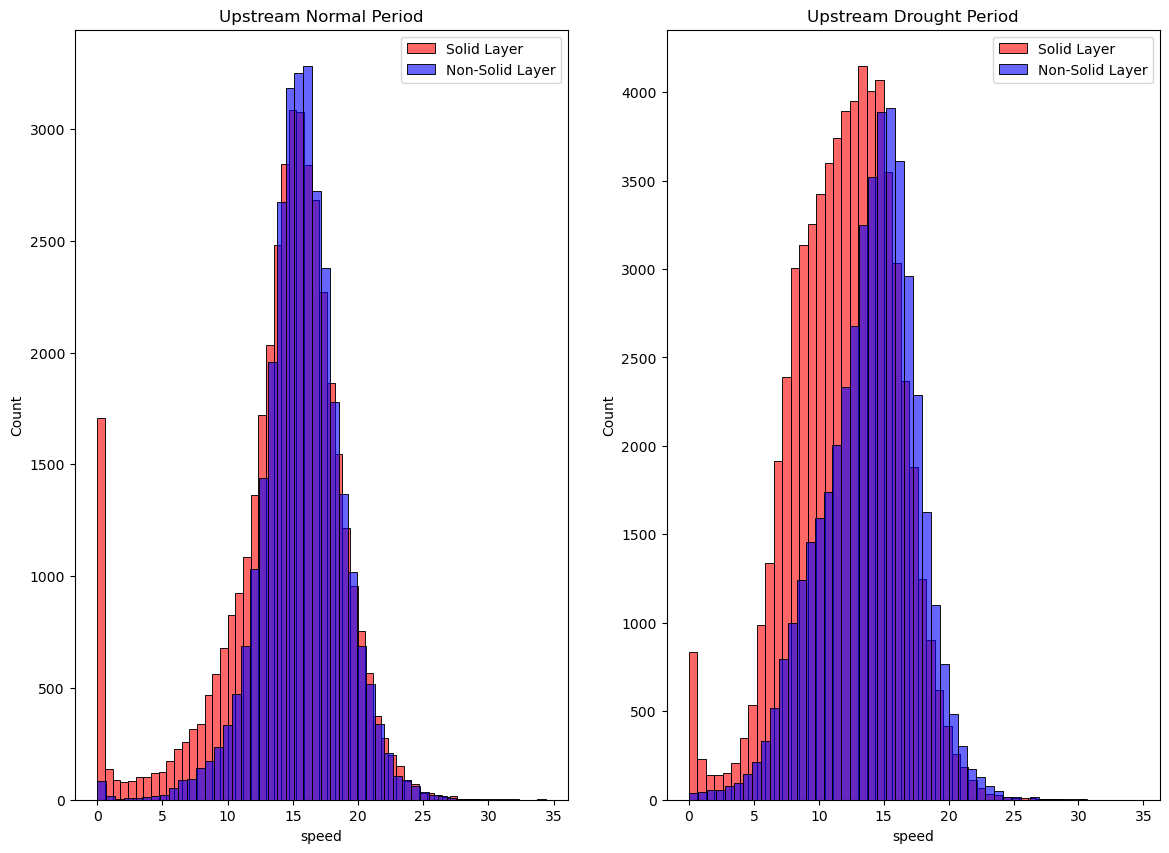

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(14, 10))


sns.histplot(data=normal_upstream_gdf[normal_upstream_gdf['solid_layer'] == True], x='speed', ax=axes[0], bins=50, color='red', label='Solid Layer', alpha=0.6)
sns.histplot(data=normal_upstream_gdf[normal_upstream_gdf['non_solid_layer'] == True], x='speed', ax=axes[0], bins=50, color='blue', label='Non-Solid Layer', alpha=0.6)

axes[0].set_title('Upstream Normal Period')
axes[0].legend()

sns.histplot(data=drought_upstream_gdf[drought_upstream_gdf['solid_layer'] == True], x='speed', ax=axes[1], bins=50, color='red', label='Solid Layer', alpha=0.6)
sns.histplot(data=drought_upstream_gdf[drought_upstream_gdf['non_solid_layer'] == True], x='speed', ax=axes[1], bins=50, color='blue', label='Non-Solid Layer', alpha=0.6)

axes[1].set_title('Upstream Drought Period')
axes[1].legend()

In [73]:
# compare the mean speed for non-solid layer and solid layer speed distributions for normal and drought periods
print('Mean speed for non-solid layer upstream normal period:', normal_upstream_gdf[normal_upstream_gdf['non_solid_layer'] == True].speed.mean())
print('Mean speed for solid layer upstream normal period:', normal_upstream_gdf[normal_upstream_gdf['solid_layer'] == True].speed.mean())

print('Mean speed for non-solid layer upstream drought period:', drought_upstream_gdf[drought_upstream_gdf['non_solid_layer'] == True].speed.mean())
print('Mean speed for solid layer upstream drought period:', drought_upstream_gdf[drought_upstream_gdf['solid_layer'] == True].speed.mean())

Mean speed for non-solid layer upstream normal period: 15.633374204782953
Mean speed for solid layer upstream normal period: 14.236140893715843
Mean speed for non-solid layer upstream drought period: 13.905036131625826
Mean speed for solid layer upstream drought period: 11.97548144401131


### G-test Solid layer

In [95]:

# Filter the speed data for non_solid_layer and solid_layer or do solid normal vs solid drought and non-solid normal vs non-solid drought.
speed_non_solid = drought_upstream_gdf[drought_upstream_gdf['non_solid_layer'] == True]['speed']
speed_solid = drought_upstream_gdf[drought_upstream_gdf['solid_layer'] == True]['speed']

# Define the bins for speed
speed_bins = np.linspace(speed_non_solid.min(), speed_non_solid.max(), 10)

# Compute histograms
hist_non_solid, bin_edges_non_solid = np.histogram(speed_non_solid, bins=speed_bins)
hist_solid, bin_edges_solid = np.histogram(speed_solid, bins=speed_bins)

# Combine the histograms into a contingency table
observed = np.array([hist_non_solid, hist_solid])

# Calculate the expected frequencies assuming no difference between groups
total_non_solid = hist_non_solid.sum()
total_solid = hist_solid.sum()
total = total_non_solid + total_solid

# Expected frequencies based on the null hypothesis
expected_non_solid = (hist_non_solid + hist_solid) * (total_non_solid / total)
expected_solid = (hist_non_solid + hist_solid) * (total_solid / total)

# Combine expected frequencies into the same structure as observed
expected = np.array([expected_non_solid, expected_solid])

# Perform the G-test on the contingency table
g_stat, p_value = power_divergence(f_obs=observed.flatten(), f_exp=expected.flatten(), lambda_='log-likelihood')

# Calculate degrees of freedom
dof = (observed.shape[0] - 1) * (observed.shape[1] - 1)

print(f'G-test statistic: {g_stat}')
print(f'p-value: {p_value}')
print(f'Degrees of freedom: {dof}')
print(f'Observed frequencies:\n{observed}')
print(f'Expected frequencies:\n{expected}')


G-test statistic: 6145.9526936938
p-value: 0.0
Degrees of freedom: 8
Observed frequencies:
[[  333  2126  8307 17221 14367  2092   141    18     4]
 [ 1663  6962 19401 23339 11338  1382    90    15     2]]
Expected frequencies:
[[8.18370824e+02 3.72612928e+03 1.13604303e+04 1.66298199e+04
  1.05391894e+04 1.42435884e+03 9.47112527e+01 1.35301790e+01
  2.46003254e+00]
 [1.17762918e+03 5.36187072e+03 1.63475697e+04 2.39301801e+04
  1.51658106e+04 2.04964116e+03 1.36288747e+02 1.94698210e+01
  3.53996746e+00]]
